# Forecasting Daily Revenue in Havaiianas, ION Orchard Singapore

Notebook prepared by Dominic Dayta for Aroodai and Lean Retail Labs

In [ ]:
import datetime


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model


# some basic plot parameters
sns.set_style('darkgrid')
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('font', size = 13)

The following notebook makes use of the cleaned sales dashboard data obtained from the ION Orchard store. Data covers information on daily sales, revenue, profits, conversion and other similar retail statistics every day, from Monday, January 1, 2018, to Sunday, July 29 of the same year.

In [ ]:
dashboard_df = pd.read_excel (r'/content/drive/MyDrive/Colab Notebooks/Data Science For Retail/Data Files/Cleaned/dashboard.xls')

dashboard_df.head()

,week_day,date,revenue,units_sold,num_transactions,basket_size,avg_transaction_value,avg_unit_value,total_discount,discount_pct,...,click_collect,online_to_offline_returns,try_non_buy,showroomers,offline_purchase_from_offline_marketing,unnamed_8,price_topseller,compete_price_topseller,compete_num_followers,compete_range_assort
0,Monday,2018-01-01,5668.30,143.0,110.0,1.300000,51.530000,39.638462,100.0,0.017336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tuesday,2018-01-02,2662.10,73.0,61.0,1.196721,43.640984,36.467123,100.0,0.036204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wednesday,2018-01-03,2759.30,74.0,72.0,1.027778,38.323611,37.287838,100.0,0.034974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thursday,2018-01-04,1784.24,31.0,38.0,0.815789,46.953684,57.556129,100.0,0.053072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Friday,2018-01-05,3375.66,72.0,62.0,1.161290,54.446129,46.884167,100.0,0.028772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Daily Revenue in Havaianas, ION Orchard

The following line plot shows the recorded daily revenue in the Havaiianas ION Orchard store. We wish to create a model that allows us to take into account this historical revenue and create a forecast that will allow management to plan ahead (i.e., manpower assignment, targets, etc).

One interesting feature we see in this plot is a sudden spike in revenue around May to June of 2018. This period with clsutered spikes usually suggests a conditional heteroskedasticity in the data, which at this point hints at our using a GARCH model for producing the forecast.

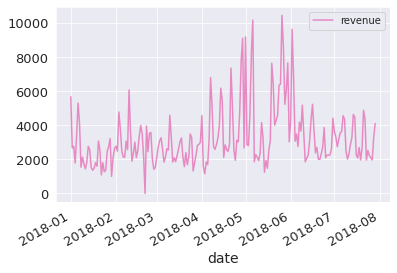

In [ ]:
dashboard_df.plot(x = "date", y = "revenue", color = sns.color_palette('Set2')[3])

## Modeling ARIMA

Prior to creating the GARCH model, we first create an ARIMA (Autoregressive Integrated Moving Average) model to account for the progression of the average daily revenue. The ARIMA model has two key components: autoregression (meaning that the expected revenue depends on expected revenue from the previous days) and the moving average model (meaning that fluctuations or error terms are correlated with error terms from the previous days).

To identify the level of autoregression and autocorrelation, we look into the autocorrelation and partial autocorrelation plots.

In [ ]:
dashboard2 = dashboard_df[["revenue","date"]].dropna()
series = dashboard2["revenue"]

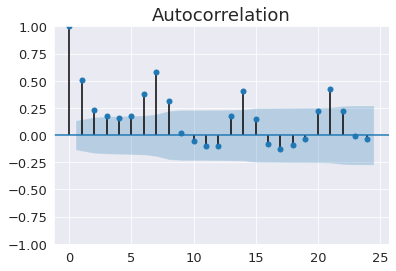

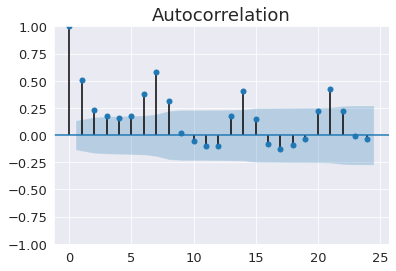

In [ ]:
plot_acf(series)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


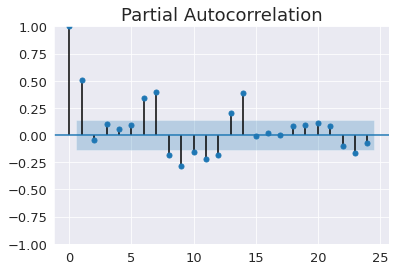

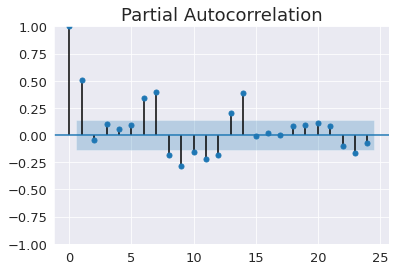

In [ ]:
plot_pacf(series)

Significant spikes in the first period with significant correlation in the ACF/PACF plots suggest either an AR(1) or an MA(1) model. We model first the MA(1) model and see the resulting fit.

In [ ]:
arima_model = ARIMA(series, order = (0,0,1))
arima_fit = arima_model.fit()

In [ ]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  210
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1840.365
Date:                Tue, 28 Jun 2022   AIC                           3686.730
Time:                        02:31:07   BIC                           3696.772
Sample:                             0   HQIC                          3690.790
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3252.4891    225.185     14.444      0.000    2811.135    3693.843
ma.L1          0.4815      0.041     11.621      0.000       0.400       0.563
sigma2      2.465e+06   1.95e+05     12.668      0.0

The above model suggests that there is a significant autocorrelation in the error terms that must be taken into account. The revenue at time $t$ can be expressed as

$$
rev_t = 3252.4891 + \varepsilon_t + 0.4815 \varepsilon_{t-1}
$$

This means that on average, revenue tends to fluctuate around an average of 3252.4891 per day, adjusted by 0.4815 for each 1 unit fluctuation from the previous time period ($\varepsilon_{t-1}$). Other AR or MA terms may be needed for this model, and to check for this, we look into the resulting ACF/PACF plot of the residual series $\varepsilon_t$.

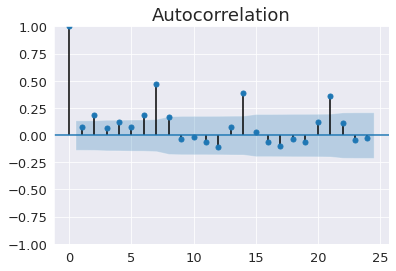

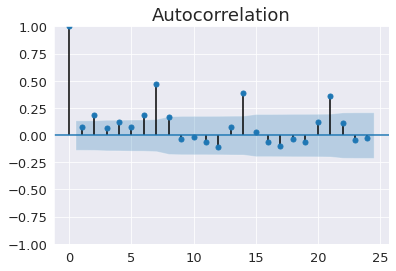

In [ ]:
arima_resid = arima_fit.resid

plot_acf(arima_resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


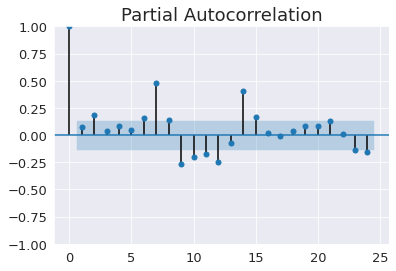

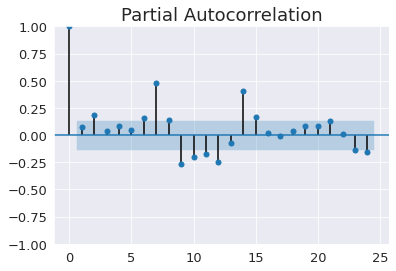

In [ ]:
plot_pacf(arima_resid)

We see another signficant though not as strong spike in correlation for the second time period. This would suggest adding either an AR(2) or an MA(2). However, we leave this out for now in favor of a simpler ARIMA model, since our expectation is that this will be controlled by accounting for GARCH errors.

Using the Weighted ARCH test by Engle, we see that there is significant heteroskedasticity in the resulting error term. This motivates our use of the GARCH model.

In [ ]:
het_arch(arima_resid) # returns LM stat, p-val, F stat, and p value

(44.91967653844087,
 2.2484998113401388e-06,
 5.47446553905967,
 3.959039047973247e-07)

The Weighted Ljung-Box test also suggests the possibility of continuing serial correlation, but once more we will return to this later after seeing the result of accounting for the GARCH errors.

In [ ]:
sm.stats.acorr_ljungbox(arima_resid)

,lb_stat,lb_pvalue
1,1.240837,2.653099e-01
2,8.548316,1.392377e-02
3,9.425994,2.413184e-02
4,12.382846,1.472021e-02
5,13.463728,1.939982e-02
6,21.032073,1.810431e-03
7,70.241462,1.320398e-12
8,76.437621,2.540821e-13
9,76.803299,6.954811e-13
10,76.862385,2.062645e-12


## Modeling Heteroskedasticity Using GARCH

Within the GARCH model, we are separately modeling the error term to account for a conditional variance $\sigma_t$ in the error terms that's varying in time rather than fixed throughout the data coverage. The error term $\varepsilon_t$ can be written as

$$
\varepsilon_t = \sigma_t w_t
$$

Which accounts for the heteroskedasticities in the model. Typically a GARCH(1,1) model is sufficient for most data, and we test that below.

In [ ]:
garch_model = arch_model(arima_resid, vol = "GARCH", p = 1, q = 1, rescale = False)
garch_fit = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1815.2892817018612
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1815.254321757137
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1815.1284329592856
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1815.1154568996326
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1815.103122300649
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1815.101742303617
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1815.1006540440567
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1815.0936905088497
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1815.0731692422742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 1815.0313318993594
Iteration:     11,   Func. Count:     71,   Neg. LLF: 1814.9226029700926
Iteration:     12,   Func. Count:     77,   Neg. LLF: 1814.6874889617668
Iteration:     13,   Func. Count:     83,   Neg. LLF: 1814.2697471090924
Iteration:     14,   Func. Count:     89,   Neg. LLF: 

In [ ]:
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1812.54
Distribution:                  Normal   AIC:                           3633.08
Method:            Maximum Likelihood   BIC:                           3646.46
                                        No. Observations:                  210
Date:                Tue, Jun 28 2022   Df Residuals:                      209
Time:                        02:06:57   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu          -194.8245     98.269     -1.983  4.742e-02 [-3.87

We are fitting this on the error term of the ARIMA model we just showed. This means that the fluctuation in $\varepsilon_t$ contains a further adjustment in mean,

$$
\varepsilon_t = -194.8245 + \sigma_t w_t
$$

Where the conditional variance $\sigma_t$ is modeled further as

$$
\sigma^2_t = 0.00047958 + 0.1173 \varepsilon^2_t + 0.8652 \sigma^2_t
$$

Because this already accounts for the heteroskedasticity in the ARIMA errors obtained earlier, the GARCH error $w_t$ should already be free of heteroskedasticity. We test this again using the Weighted ARCH test, which no longer returns a significant result.

In [ ]:
garch_fit.arch_lm_test(lags = 1, standardized = True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 0.0053
P-value: 0.9418
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6eb8eaad90

Likewise, the Weighted Ljung-Box test no longer returns significant p-values for any of the lags (except for lags 7 and 8, which we consider too far in time to be meaningful).

In [ ]:
sm.stats.acorr_ljungbox(garch_resid)

,lb_stat,lb_pvalue
1,1.854803,1.732258e-01
2,3.337186,1.885121e-01
3,3.340558,3.420375e-01
4,3.597301,4.632386e-01
5,3.960621,5.550994e-01
6,15.188768,1.883825e-02
7,67.205663,5.412084e-12
8,78.797637,8.532494e-14
9,79.936046,1.664102e-13
10,80.347056,4.292447e-13


The spike in the ACF/PACF plot for time period 2 that we saw also after modeling ARIMA no longer appears in the ACF/PACF plot after GARCH.

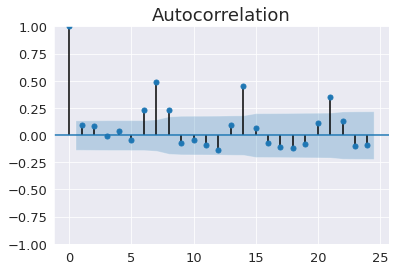

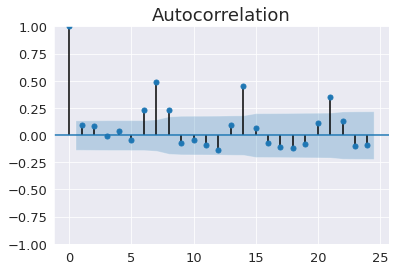

In [ ]:
plot_acf(garch_resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


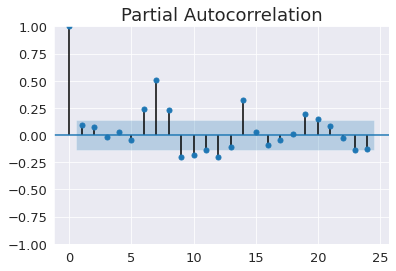

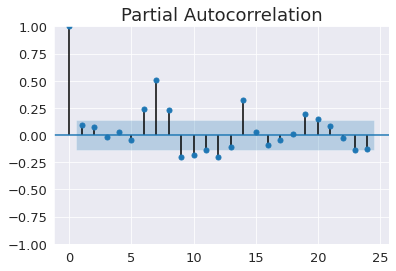

In [ ]:
plot_pacf(garch_resid)

## Forecasting Future Revenue

Now that we have a working model for the daily revenue, we can finally produce the forecast. We will forecast the expected revenue for the next 10 days, although it should be noted that only the first day of the forecast will be reliable enough for actual use. First we forecast the average returns for the ARIMA model.

In [ ]:
arima_fit.forecast(10)

210    3543.701357
211    3252.489052
212    3252.489052
213    3252.489052
214    3252.489052
215    3252.489052
216    3252.489052
217    3252.489052
218    3252.489052
219    3252.489052
Name: predicted_mean, dtype: float64

After the ARIMA forecast, we also forecast the error terms through the GARCH model.

In [ ]:
garch_forecast = garch_fit.forecast(horizon = 10, reindex = False)
garch_forecast.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
209,-194.824521,-194.824521,-194.824521,-194.824521,-194.824521,-194.824521,-194.824521,-194.824521,-194.824521,-194.824521


The ARIMA terms plus the GARCH errors produces our forecast for the next ten days. From this forecast we can see that we are expecting a revenue of 3,348.88 SGD on the first day after the last record in the data, which is for June 30. After that, for the next nine days we are expecting revenue of about 3,057.66 SGD, but again this will have to be adjusted given the autocorrelated nature of revenue as observed through the ARIMA and GARCH models.

In [ ]:
garch_et = pd.DataFrame(garch_forecast.mean).transpose().reset_index().iloc[:,1]

arima_forecast = arima_fit.forecast(10)
arima_mean = arima_forecast.reset_index().iloc[:,1]

arima_mean + garch_et

0    3348.876836
1    3057.664531
2    3057.664531
3    3057.664531
4    3057.664531
5    3057.664531
6    3057.664531
7    3057.664531
8    3057.664531
9    3057.664531
dtype: float64

In [ ]:
new_series = arima_mean + garch_et

first_dates = dashboard2["date"]
last_date = first_dates[209]
forecast_horizon = pd.date_range(last_date + datetime.timedelta(days=1), periods=10)
x = pd.DataFrame({'date' : forecast_horizon.strftime("%Y-%m-%d %H:%M:%S")})

predicted = pd.DataFrame({
    'date' : first_dates.append(x['date']),
    'revenue' : series.append(new_series)
})

In [ ]:
predicted = predicted.set_index("date")

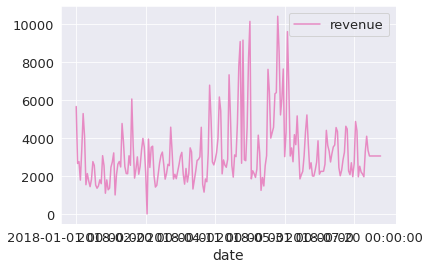

In [ ]:
predicted.plot(color = sns.color_palette('Set2')[3])